In [1]:
BATCH_SIZE = 64
IMAGE_SIZE = 224
EPOCHS = 10

## Загрузка данных

In [2]:
from google.colab import drive
from pathlib import Path


drive.mount('/content/drive/')

path = Path("/content/drive/My Drive/Skillbox/emotions")
path.mkdir(exist_ok=True, parents=True)
assert path.exists()

Mounted at /content/drive/


In [3]:
import zipfile


with zipfile.ZipFile("/content/drive/My Drive/Skillbox/emotions/train.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

with zipfile.ZipFile("/content/drive/My Drive/Skillbox/emotions/test_kaggle.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [6]:
import os
import shutil


folder_path = "/content/train"

# Создание подпапок для тренировочного и тестового наборов данных
train_folder = '/content/train_data'
test_folder = '/content/test_data'

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)


# Получение списка подпапок в исходной папке
subfolders = os.listdir(folder_path)

# Разделение каждой подпапки на тренировочный и тестовый наборы данных
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    subfolder_train_path = os.path.join(train_folder, subfolder)
    subfolder_test_path = os.path.join(test_folder, subfolder)

    os.makedirs(subfolder_train_path, exist_ok=True)
    os.makedirs(subfolder_test_path, exist_ok=True)

    # Получение списка файлов в текущей подпапке
    files = os.listdir(subfolder_path)
    # Разделение файлов на тренировочный и тестовый наборы данных
    num_train_files = int(0.75 * len(files))  # 75% для тренировочного набора
    train_files = files[:num_train_files]
    test_files = files[num_train_files:]

    # Копирование файлов в соответствующие подпапки
    for file in train_files:
        shutil.copy(os.path.join(subfolder_path, file), os.path.join(subfolder_train_path, file))

    for file in test_files:
        shutil.copy(os.path.join(subfolder_path, file), os.path.join(subfolder_test_path, file))


## Подготовка модели vggface (+ препроцессинг и депроцесснг)

In [5]:
! pip install git+https://github.com/rcmalli/keras-vggface.git
! pip install gdown

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-wsd0hnxk
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-wsd0hnxk
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8294 sha256=959e3f7134b9b5bd34123c6b75c00316285bf3cdf31c1778251a4fcddb6f5f07
  Stored in directory: /tmp/pip-ephem-wheel-cache-ct2r166n/wheels/62/cd/e0/3a2d2fe84d014324aed54d420cab52df65a774d9b296c63996
Successfully built keras-vggface


In [7]:
import gdown
from tensorflow.keras.models import load_model


url = 'https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO'
output = 'resnet50face.h5'
gdown.download(url, output, quiet=False)


vggface_model = load_model("resnet50face.h5")

Downloading...
From (original): https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO
From (redirected): https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO&confirm=t&uuid=aa4e9475-1d8f-4fb2-86d1-57bb7b4efb9b
To: /content/resnet50face.h5
100%|██████████| 166M/166M [00:04<00:00, 36.0MB/s]


In [8]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image


def preprocess_input_facenet_func(x, data_format=None, version=2):
    """Препроцессинг для модели vggface"""
    x_temp = np.copy(x)
    x_temp = image.img_to_array(x_temp)
    x_temp = np.expand_dims(x_temp, axis=0)
    if data_format is None:
        data_format = K.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}


    if version == 1:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 93.5940
            x_temp[:, 1, :, :] -= 104.7624
            x_temp[:, 2, :, :] -= 129.1863
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 93.5940
            x_temp[..., 1] -= 104.7624
            x_temp[..., 2] -= 129.1863


    elif version == 2:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 91.4953
            x_temp[:, 1, :, :] -= 103.8827
            x_temp[:, 2, :, :] -= 131.0912
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 91.4953
            x_temp[..., 1] -= 103.8827
            x_temp[..., 2] -= 131.0912
    else:
        raise NotImplementedError


    return x_temp

In [9]:
from keras.preprocessing.image import ImageDataGenerator


def preprocess_input_facenet(image_):
    """
    image_ -- тензор размера (1, H, W, 3)
    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface
    """
    preprocessed = preprocess_input_facenet_func(image_)
    return preprocessed


def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) картинка после препросессинга.
    содержит отрицательные значения и некорректно отображается matplotlib

    return: корректно отображаеая картинка типа np.uint8(!!).
    работа с копией картинки
    """
    x_temp = np.copy(vggface_image)
    x_temp[..., 0] += 91.4953
    x_temp[..., 1] += 103.8827
    x_temp[..., 2] += 131.0912
    x_temp = x_temp [..., ::-1]
    x_temp = x_temp.astype(np.uint8)
    return x_temp

## Подготовка дата генераторов

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_folder_path = '/content/train_data'
test_folder_path = '/content/test_data'

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

common = {
    'batch_size': BATCH_SIZE,
    'target_size': (IMAGE_SIZE, IMAGE_SIZE),
    'class_mode': "categorical",
}

train_image_generator = image_gen.flow_from_directory(
    train_folder_path, shuffle=True, **common)

test_image_generator = image_gen.flow_from_directory(
    test_folder_path, shuffle=True, **common)

Found 37533 images belonging to 9 classes.
Found 12514 images belonging to 9 classes.


In [11]:
import numpy as np

sample_images, sample_labels = next(train_image_generator)
assert sample_images.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), "Неправильный размер батча"
assert sample_labels.shape == (BATCH_SIZE, 9), "Неправильный размер меток класса"
assert list(sorted(np.unique(sample_labels))) == [0., 1.], "Ожидаемые классы 0 и 1"
print("Simple tests passed")

Simple tests passed


## Работа с архитектурой модели

In [ ]:
!pip install livelossplot

In [ ]:
# уберем у vggface_model последний слой классификатора
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
# base_model.summary()

In [ ]:
# Устанавливаем trainable на True
base_model.trainable = True

# Замораживаем все слои, кроме последних 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential


# Создаем полносвязную часть модели для классификации эмоций
face_model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

In [ ]:
# КОЛБЕКИ
from tensorflow.keras.callbacks import EarlyStopping


cpt_filename_face = "best_cpt_first_model_face.hdf5"
cpt_path_face = str(path / cpt_filename_face)

early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5)

checkpoint_face = tf.keras.callbacks.ModelCheckpoint(cpt_path_face,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')

In [ ]:
# Создание и компиляция модели
face_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

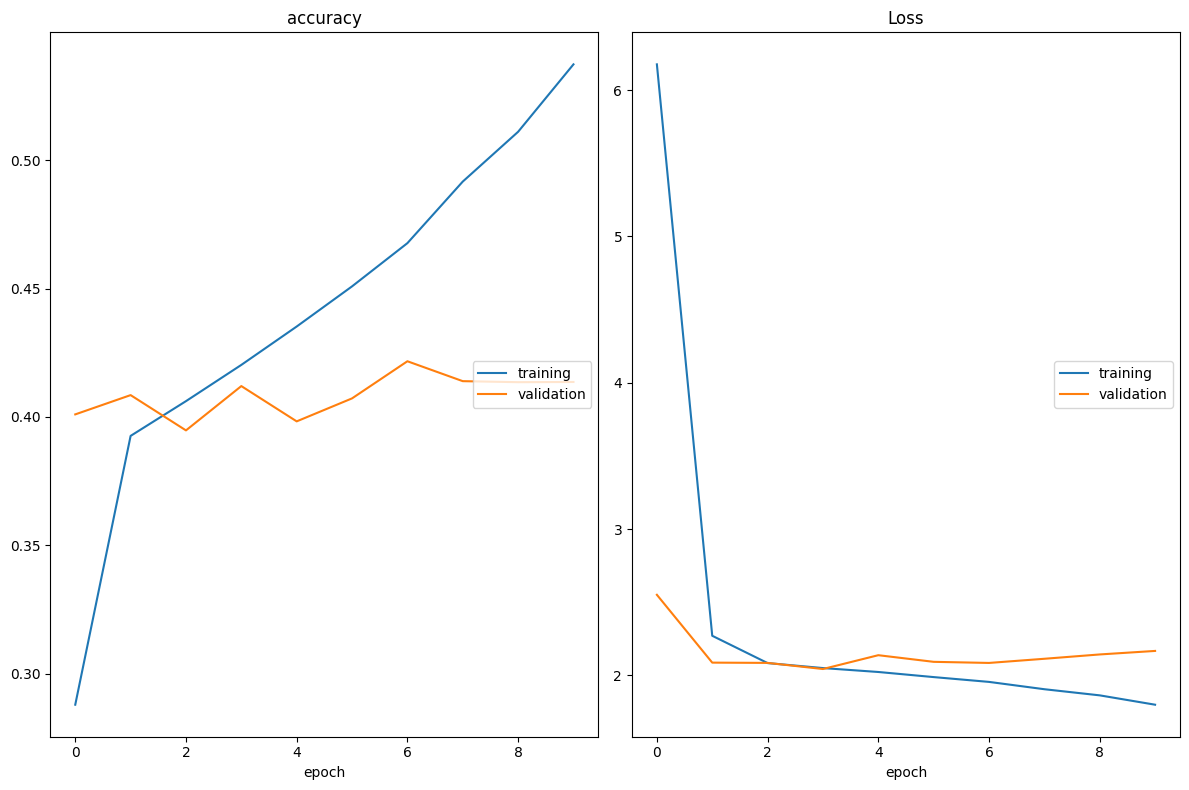

accuracy
	training         	 (min:    0.288, max:    0.537, cur:    0.537)
	validation       	 (min:    0.395, max:    0.422, cur:    0.414)
Loss
	training         	 (min:    1.800, max:    6.176, cur:    1.800)
	validation       	 (min:    2.044, max:    2.551, cur:    2.168)

Epoch 10: val_accuracy did not improve from 0.42169
587/587 [==============================] - 261s 445ms/step - loss: 1.8002 - accuracy: 0.5373 - val_loss: 2.1677 - val_accuracy: 0.4136


In [ ]:
from livelossplot.tf_keras import PlotLossesCallback

# Обучаем модель
history3 = face_model.fit(
    train_image_generator,
    epochs=EPOCHS,
    validation_data=test_image_generator,
    callbacks=[PlotLossesCallback(), checkpoint_face, early_stopping_callback])

## Загрузка лучшей модели и инференс

In [12]:
from tensorflow.keras.models import load_model

# Загрузить модель
model_path = '/content/drive/MyDrive/Skillbox/emotions/best_cpt_first_model_face.hdf5'
model = load_model(model_path)

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os


# Путь к папке с изображениями
test_image_kaggle_dir = '/content/test_kaggle'
image_paths = [os.path.join(test_image_kaggle_dir, img) for img in os.listdir(test_image_kaggle_dir)]

# Создание DataFrame с путями к изображениям
df = pd.DataFrame({'filename': image_paths})

# Создание генератора для тестовых изображений
test_generator = image_gen.flow_from_dataframe(
    dataframe=df,
    x_col='filename',
    y_col=None,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 5000 validated image filenames.


In [52]:
df[:3]

,filename
0,/content/test_kaggle/4751.jpg
1,/content/test_kaggle/4797.jpg
2,/content/test_kaggle/4336.jpg


2/2 [==============================] - 0s 106ms/step


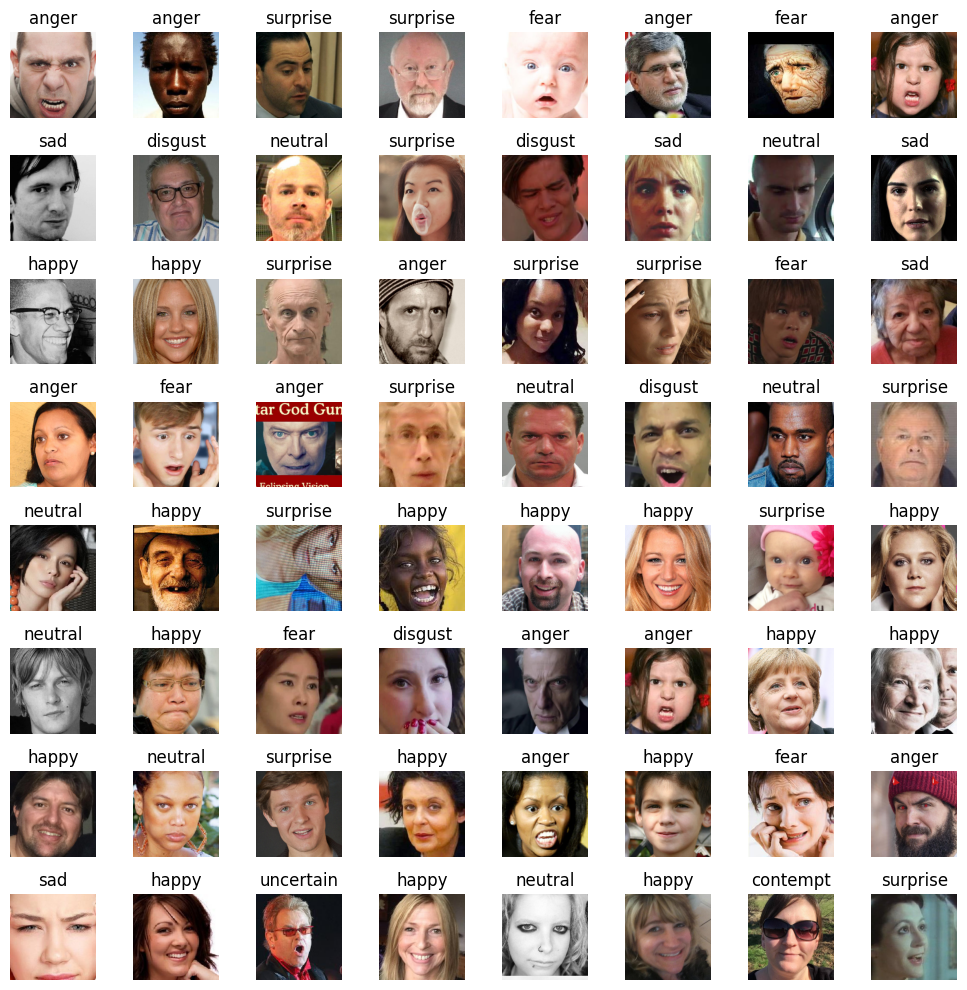

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Эмоции
emotion_labels = ['anger', 'contempt', 'disgust', 'fear',
                  'happy', 'neutral', 'sad', 'surprise', 'uncertain']


def predict_and_display_images(num_images=BATCH_SIZE):
    """Функция для предсказания и отображения изображений с эмоциями"""
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    axes = axes.ravel()

    predictions = []

    # Получаем один батч изображений
    img_array = test_generator.next()
    preds = model.predict(img_array)

    for i in range(num_images):
        # Проверяем, не вышли ли мы за пределы количества изображений
        if i >= len(test_generator.filenames):
            break

        emotion = emotion_labels[np.argmax(preds[i])]

        # Сохраняем результат предсказания
        image_name = os.path.basename(test_generator.filenames[i])
        predictions.append((image_name, emotion))

        # Отображаем изображение и предсказанную эмоцию
        img = img_array[i]
        img = deprocess_image(img)  # обратная нормализация
        axes[i].imshow(img)
        axes[i].set_title(emotion)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    return predictions


predictions = predict_and_display_images()

In [ ]:
# повторно определим генератор
test_generator = image_gen.flow_from_dataframe(
    dataframe=df,
    x_col='filename',
    y_col=None,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [56]:
# Функция для предсказания эмоций для всех изображений
def predict_all_emotions(batch_size=BATCH_SIZE):
    predictions = []
    total_steps = test_generator.samples // batch_size + (test_generator.samples % batch_size != 0)

    for step in range(total_steps):
        img_array = test_generator.next()
        preds = model.predict(img_array)

        for i, pred in enumerate(preds):
            # if step * batch_size + i >= len(test_generator.filenames):
            #     break
            # print(step, img_array)
            emotion = emotion_labels[np.argmax(pred)]
            image_name = os.path.basename(test_generator.filenames[step * batch_size + i])
            predictions.append((image_name, emotion))

    return predictions


all_predictions = predict_all_emotions()

1/1 [==============================] - 0s 38ms/step


In [57]:
# Создание DataFrame с предсказанными эмоциями
prediction_df = pd.DataFrame(all_predictions, columns=['image_path', 'emotion'])
prediction_df.to_csv('/content/submission.csv', index=False)
prediction_df.head()

,image_path,emotion
0,4751.jpg,happy
1,4797.jpg,happy
2,4336.jpg,surprise
3,2362.jpg,happy
4,1117.jpg,surprise


In [58]:
prediction_df.shape

(5000, 2)

In [59]:
len(test_generator.filenames)

5000